<a href="https://colab.research.google.com/github/Ali-Jasim/rl-routing/blob/master/env_notebook_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import uuid
import networkx as nx
import numpy as np

In [14]:
#@title Wire
class Wire:
    def __init__(self, router1, router2):
        # connection between two routers
        self.router1 = router1
        self.router2 = router2
        # need a tuple to jump on graph
        self.jump = (router1.id, router2.id)
        # list of packets on wire
        # acting as input buffer
        self.packets = []

    def __eq__(self, other):
        if not isinstance(self, type(other)):
            return False

        return (self.router1 is other.router1) and (self.router2 is other.router2)

    def __repr__(self):
        return f"{self.router1.id},{self.router2.id}\n"

    def find_packet(self, packet):
        for p in self.packets:
            if p is packet:
                return packet

        return None

    def is_active(self):
        return len(self.packets) != 0

    def insert_packet(self, packet):
        self.packets.append(packet)

    def remove_packet(self, packet, dst):
        p = self.find_packet(packet)

        if dst == self.router1.id:
            return self.hop(p, self.router1)
        elif dst == self.router2.id:
            return self.hop(p, self.router2)

    def hop(self, packet, dst):
        # if we successfully hopped to router, remove packet
        if packet and dst.insert_packet(packet):
            self.packets.remove(packet)
            return dst

        # operation failure, dst router congested
        return None

    def clear_buffer(self):
        self.packets = []


In [15]:
#@title Router
class Router:
    def __init__(self, id, kind, network, buffer_size):
        # node on graph
        self.id = id
        self.network = network
        # avoiding using type, better name?
        self.kind = kind

        # edges connected to this node
        # list of wires connected to routers
        self.connections = []
        self.actions = []

        # if packet completes path, flag successful completion
        self.completed = False

        # depending on type, set buffer size
        if kind == 'T':
            # change this to hold more packets
            self.buffer_size = int(buffer_size*2)
        elif kind == 'M':
            # change this to hold more packets
            self.buffer_size = int(buffer_size*1.5)
        elif kind == 'C' or kind == 'CP':
            self.buffer_size = buffer_size

        self.buffer = []

    def __eq__(self, other):
        if not isinstance(self, type(other)):
            return False

        return self.id == other.id

    def __repr__(self):
        return f"id: {self.id}, type: {self.kind}\n connections: {self.connections}\n"

    # for visualization we need to know
    # if the router is full, active, and inactive
    # full = red; active = yellow; inactive = grey
    # if we recieved packets destined on this step, flag completed true
    def is_full(self):
        return len(self.buffer) >= self.buffer_size

    def is_active(self):
        return len(self.buffer) != 0

    def is_completed(self):
        return self.completed

    def reset_completed(self):
        self.completed = False

    # can only add and find connections
    def has_connection(self, dst):
        for connection in self.connections:
            node1, node2 = connection.jump
            if dst == node1 or dst == node2:
                return connection

        return None

    def build_connections(self, wires):
        for wire in wires:
            if self is wire.router1 or self is wire.router2:
                self.connections.append(wire)

    def build_actions(self):
        for connection in self.connections:
            r1, r2 = connection.jump
            if r1 != self.id:
                self.actions.append(r1)
            elif r2 != self.id:
                self.actions.append(r2)

    # packet control operations
    def insert_packet(self, packet):
        # if this is the dst router, accept regardless of buffer size
        if self is packet.dst:
            self.completed = True
            return True
        elif not self.is_full():
            # enqueue packet
            self.buffer.append(packet)
            return True

        return False

    # push to wire
    def remove_packet(self, packet, dst):
        # if there is a connection to the destination
        # and the buffer is not empty
        # and the packet exists
        # move packet to wire
        wire = self.has_connection(dst)
        packet_index = self.find_packet(packet)
        if wire and self.buffer and packet_index != -1:
            # dequeue packet

            self.buffer.remove(packet)
            wire.insert_packet(packet)

            # wire.insert_packet(packet)
            return wire

    def find_packet(self, packet):
        for index, p in enumerate(self.buffer):
            if p is packet:
                return index
        return -1

    def clear_buffer(self):
        self.buffer = []

    # cant generate packets here, must generate from network and insert to routers
    # centralized controller controls packet path


In [16]:
#@title Packet Class
class Packet:
    def __init__(self, src, dst, graph, path=[]):
        self.id = str(uuid.uuid4())
        self.src_id = src.id
        self.dst_id = dst.id
        self.curr = src
        self.curr_router = src  # we need to know src router for each hop on wire
        self.next_router = None  # updated on path update
        self.src = src
        self.dst = dst
        self.graph = graph  # change this to network on vscode
        self.reward = 0
        #self.path = self.update_path()

# possibly return possible actions in current router
# possible actions = where we can hop

    # add an equal method to find
    def __eq__(self, other):
        if not isinstance(self, type(other)):
            return False

        return self.id == other.id

    def __repr__(self):
        return f"id: {self.id},\n curr: {self.curr_router}, dst: {self.dst}"

    def on_wire(self):
        return isinstance(self.curr, Wire)

    def on_router(self):
        return isinstance(self.curr, Router)

    def get_actions(self):
        if isinstance(self.curr, Router):
            return self.curr.actions

    def choose_action(self, action):
        self.next_router = action

    def validate_action(self):
        if self.next_router in self.curr.actions:
            self.reward = 1
            return True

        self.reward = -2
        self.next_router = None
        # as per paper, -2 for invalid actions
        return False

    # this is the input buffer for the next router

    def push_to_wire(self):
        if isinstance(self.curr, Router):
            if self.validate_action():
                self.curr = self.curr.remove_packet(self, self.next_router)
                self.next_router = self.next_router

    def push_to_router(self):
        if isinstance(self.curr, Wire):
            router = self.curr.remove_packet(self, self.next_router)
            if router:
                self.curr_router = router
                self.curr = router
                self.next_router = None
                # self.update_path()
                return 0
            else:
                # big negative reward for congestion
                self.reward = -5
                return 1
            # otherwise we stay on wire

    def complete(self):
        return self.curr is self.dst

    def update_next_hop(self, dst):
        self.next_router = dst

    # build a more sophisticated path finding function, for now, shortest path
    def choose_action_shortest(self):
        self.path = nx.shortest_path(
            self.graph, self.curr_router.id, self.dst.id)
        if len(self.path) >= 2:
            self.next_router = self.path[1]


In [17]:
#@title Network Class

class Network:
    def __init__(self, router_num=25, buffer_size=10):
        # initialize networkx backend
        self.network = self.init_network(router_num)

        # initialize network variables

        # all the routers and wires
        self.routers = []
        self.wires = []
        self.all_actions = []
        self.buffer_sizes = []
        self.src_dst = []

        # reward for each step
        self.total_reward = 0

        # the routers that can generate new packets
        self.customer_routers = []
        self.customer_buffer_size = buffer_size

        # total amount of packets
        self.packets = []

        self.congestion_count = 0

        self.all_router_data = np.array(self.network.nodes.data())
        self.all_connections = np.array(self.network.edges())

        # build network
        self.build_network()

    def step(self, p):
        reward = 0
        done = False
        next_packet = None
        for packet in self.packets:
            if packet is p:
                if not packet.complete():
                    if isinstance(packet.curr, Router):
                        # if the next hop routers buffer is full, packet stays on wire and retry
                        # next iteration of loop
                        # simulated CONGESTION!!
                        # todo: add negative reward and keep track of congestion rate
                        packet.push_to_wire()

                        # packet.choose_action_shortest()
                        congestion = packet.push_to_router()
                        if congestion == 1:
                            next_packet = None

                        next_packet = packet
                    else:
                        congestion = packet.push_to_router()
                        if congestion == 1:
                            next_packet = None

                    reward = packet.reward
                else:
                    reward = 100
                    done = True
                    #reward += packet.reward
                    self.packets.remove(packet)

        self.update_buffer_sizes()
        self.total_reward += reward
        return reward, done, next_packet

    def shortest_path_step(self):
        # loop through all packets, hop on each timestep
        reward = 0
        for packet in self.packets:
            # packet step if not complete
            if not packet.complete():
                # if the next hop routers buffer is full, packet stays on wire and retry
                # next iteration of loop
                # simulated CONGESTION!!
                # todo: add negative reward and keep track of congestion rate
                if packet.on_wire():
                    self.congestion_count += packet.push_to_router()
                else:
                    packet.choose_action_shortest()
                    packet.push_to_wire()

                reward += packet.reward
            else:
                # print and remove packet on arrival
                # print(packet)
                self.packets.remove(packet)

        self.update_buffer_sizes()
        self.total_reward += reward
        return reward

    def generate_packets(self, amount=1):
        if not amount > self.customer_buffer_size:
            for router in self.customer_routers:
                src = self.routers[router.id]
                #rng = np.random.randint(amount)
                for _ in range(amount-1):
                    dst = np.random.choice(self.customer_routers)
                    # dst cannot be the same src
                    # you cannot send packets to yourself
                    while src is dst:
                        dst = np.random.choice(self.customer_routers)
                    else:
                        p = Packet(src, dst, self.network)
                        self.routers[src.id].insert_packet(p)
                        self.packets.append(p)
            # update paths
            self.update_src_dst()
        else:
            raise Exception(
                f"cannot generate more packets than buffer size: {self.customer_buffer_size}")

    def update_packet_hop(self, packet, dst):
        for p in self.packets:
            if p == packet:
                p.update_next_hop(dst)

    def update_buffer_sizes(self):
        new_buffer = []
        for router in self.routers:
            new_buffer.append(
                [router.id, len(router.buffer)/router.buffer_size])

        self.buffer_sizes = new_buffer

    def update_src_dst(self):
        for packet in self.packets:
            self.src_dst.append([packet.src_id, packet.dst_id])

    # low level initialization details

    def init_network(self, n):
        G = nx.random_internet_as_graph(n)
        # for visualization we can set a layout for nodes
        pos = nx.spring_layout(G)
        nx.set_node_attributes(G, pos, "pos")
        #nx.set_node_attributes(G, {})
        # for visualization
        self.pos = nx.get_node_attributes(G, "pos")

        return G

    def build_network(self):
        self.build_routers(self.customer_buffer_size)
        self.build_wires()
        self.connect_routers()
        self.update_buffer_sizes()

    def connect_routers(self):
        for router in self.routers:
            router.build_connections(self.wires)
            router.build_actions()

    def build_routers(self, buffer_size):
        # extract data from nodes and edges and map
        for node in self.all_router_data:
            id = node[0]
            kind = node[1]['type']
            r = Router(id=id, kind=kind, network=self.network,
                       buffer_size=buffer_size)
            self.routers.append(r)

            if kind == 'C' or kind == 'CP':
                self.customer_routers.append(r)

        self.all_actions = [i for i in range(len(self.routers))]

    def build_wires(self):
        for connection in self.all_connections:
            router_id_1 = connection[0]
            router_id_2 = connection[1]
            wire = Wire(self.routers[router_id_1], self.routers[router_id_2])
            self.wires.append(wire)


In [18]:
#@title Environment class
# visualization libraries
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
from matplotlib import pyplot as plt
import cv2


class env:
    def __init__(self, num_routers=25, customer_buffer_size=10):
        # initialize network environment
        self.network = Network(num_routers, customer_buffer_size)
        self.num_routers = num_routers
        self.customer_buffer_size = customer_buffer_size

        # visualization
        self.fig = Figure(figsize=(8, 8))
        self.canvas = FigureCanvas(self.fig)

    def reset(self):
        self.network.generate_packets(self.customer_buffer_size - 1)
        self.network.congestion_count = 0

        return self.create_observation()

    def render(self, mode='opencv'):
        # two modes, matplotlib and opencv

        # matplotlib for jupyter notebook environment
        # opencv for python environment
        # always return matrix representing image of network graph

        # for routers in network
        ACTIVE_ROUTER = 'yellow'
        INACTIVE_ROUTER = 'grey'
        FULL = 'red'
        COMPLETED = 'lawngreen'

        # for wires in network
        ACTIVE_WIRE = 'green'
        INACTIVE_WIRE = 'blue'

        node_color = []
        for router in self.network.routers:
            if router.is_full():
                node_color.append(FULL)
            elif router.is_completed():
                node_color.append(COMPLETED)
                router.reset_completed()
            elif router.is_active():
                node_color.append(ACTIVE_ROUTER)
            else:
                node_color.append(INACTIVE_ROUTER)

        edge_color = []
        for wire in self.network.wires:
            if wire.is_active():
                edge_color.append(ACTIVE_WIRE)
            else:
                edge_color.append(INACTIVE_WIRE)

        edge_weight = [2 for _ in range(len(self.network.wires))]

        options = {
            "node_color": node_color,
            "edge_color": edge_color,
            "width": edge_weight,
        }
        # generate image and return
        ax = self.fig.gca()
        nx.draw(self.network.network, pos=self.network.pos, ax=ax, **options)
        self.canvas.draw()

        if mode == 'opencv':
            # convert to opencv image for display
            img = np.fromstring(self.canvas.tostring_rgb(), dtype=np.uint8,
                                sep='')
            img = img.reshape(self.canvas.get_width_height()[::-1] + (3,))
            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        elif mode == 'matplotlib':
            # convert to matplotlib img
            img = np.fromstring(self.canvas.tostring_rgb(), dtype=np.uint8,
                                sep='')
            img = img.reshape(self.canvas.get_width_height()[::-1] + (3,))

        return img

    # action here will be a list of packets and next hop
    def step(self, custom=False):
        # our agent takes a step
        if custom:
            return
        else:
            # just take shortest path
            reward = self.network.shortest_path_step()

        info = []
        return self.create_observation(), reward, self.done(), info

    def done(self):
        return len(self.network.packets) == 0

    # return list of all actions, buffer sizes, src id, dst id
    # return state of network, and anything related to the packets

    def create_observation(self):

        # this shows connectivity of graph
        # good repersentation for neural network
        adj_matrix = np.array(nx.adjacency_matrix(self.network.network))
        # grab buffer_sizes in network
        buffers = np.array(self.network.buffer_sizes)
        # grab all packets src and dst
        packet_path = np.array(self.network.src_dst)
        # grab all actions
        all_actions = np.array(self.network.all_actions)

        # convert to tensor
        return np.array([adj_matrix, buffers, all_actions, packet_path])

    # attempt #1, choose action for every packet on every timestep
    def get_actions(self):
        all_packets = np.array(self.network.packets)

        return all_packets

    def choose_action(self, packet, dst):
        self.network.update_packet_hop(packet, dst)

# todo : add customizable agent

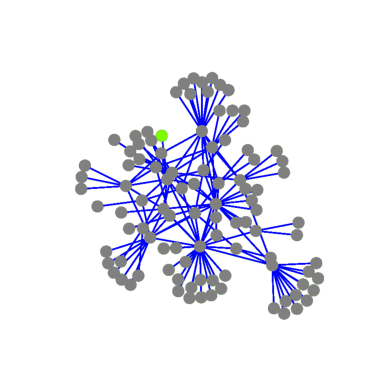

reward: 0
steps: 27
total_reward: -14613


In [19]:
#@title Example Usage
from IPython import display
from IPython.display import clear_output
import pylab as pl
import time
%matplotlib inline

e = env(100, 10)
# e.reset()
episodes = 10


steps = []
eps = []


for ep in range(episodes):
    e.reset()
    n = 0
    total_reward = 0
    while not e.done():
        clear_output(wait=True)
        plt.axis("off")
        plt.imshow(e.render(mode='matplotlib'))
        plt.show()

        #shortest path implemented internally if user does not set actions
        observation, reward, done, info = e.step(None)
        total_reward += reward
        n += 1

        print(f"reward: {reward}")
        print(f"steps: {n}")
        print(f"total_reward: {total_reward}")
        
        

    steps.append(n)
    eps.append(ep)


print(f"completed in average {np.mean(n)} timesteps")
